In [1]:
from system import *

e_field = zero_field()
b_field = harris_cs_model(100e-9, 0.15, Re)
system  = System(e_field, b_field)

Load IGRF coefficients ...


In [2]:
system.populate(10000,
                delta(np.array([0, 0, -10 * Re])),
                delta(1.5e6),
                uniform(np.radians(0), np.radians(90)),
                uniform(0, 2 * np.pi)
               )

100%|██████████| 10000/10000 [00:02<00:00, 3401.80it/s]


In [3]:
system.solve(4, 1e-4)

100%|██████████| 10000/10000 [05:29<00:00, 30.32it/s]


In [4]:
from math import floor
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 16})

def pa_evolution(history, h_bins, v_bins, T):
    pas = pitch_angle(history)
    pas_map = np.zeros((v_bins, h_bins))

    h_max = len(pas[0, :])

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        pas_at_t = pas[:, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 180, num=v_bins + 1), density=True)[0])
        
    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma')
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(180, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title('Evolution of pitch angle distribution')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    plt.show()

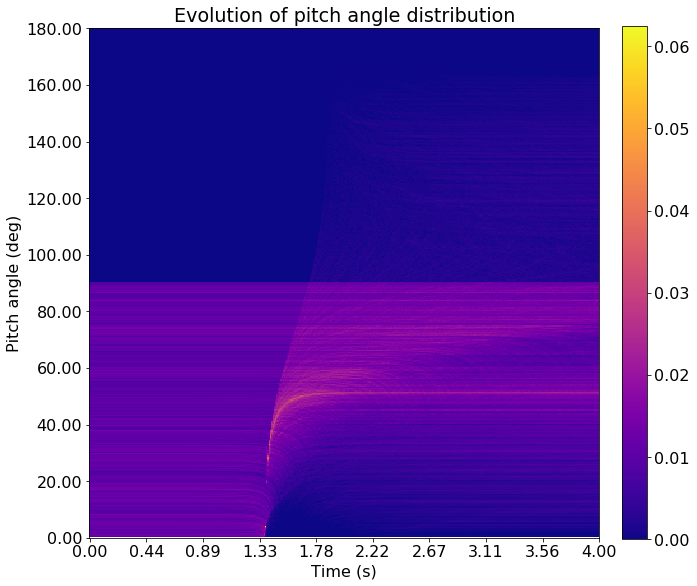

In [5]:
pa_evolution(system.history, 400, 400, 4)

In [6]:
from math import floor
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 16})

def clamped_pa_evolution(history, h_bins, v_bins, T):
    pas = pitch_angle(history)
    pas_map = np.zeros((v_bins, h_bins))
    
    for i in range(len(pas[:, 0])):
        for j in range(len(pas[0, :])):
            p = pas[i, j]
            
            if p <= 90:
                continue
            else:
                pas[i, j] = 180 - p

    h_max = len(pas[0, :])

    for i, t in enumerate(np.linspace(0, h_max - 1, num=h_bins, endpoint=False)):
        t_ind = floor(t)
        pas_at_t = pas[:, t_ind]
        pas_map[:, i] = np.flip(np.histogram(pas_at_t, bins=np.linspace(0, 90, num=v_bins + 1), density=True)[0])
        
    fig = plt.figure(figsize=(10 * (h_bins / v_bins), 10)) 
    cax = plt.gca()
    
    im = cax.imshow(pas_map, cmap='plasma')
    
    plt.yticks(np.linspace(0, v_bins, 10), [f'{k:.2f}' for k in np.linspace(90, 0, 10)])
    plt.xticks(np.linspace(0, h_bins, 10), [f'{k:.2f}' for k in np.linspace(0, T, 10)])
    
    plt.ylabel('Pitch angle (deg)')
    plt.xlabel('Time (s)')
    plt.title('Evolution of pitch angle distribution')
    
    plt.colorbar(im, ax=cax, fraction=0.046, pad=0.04)
    plt.show()

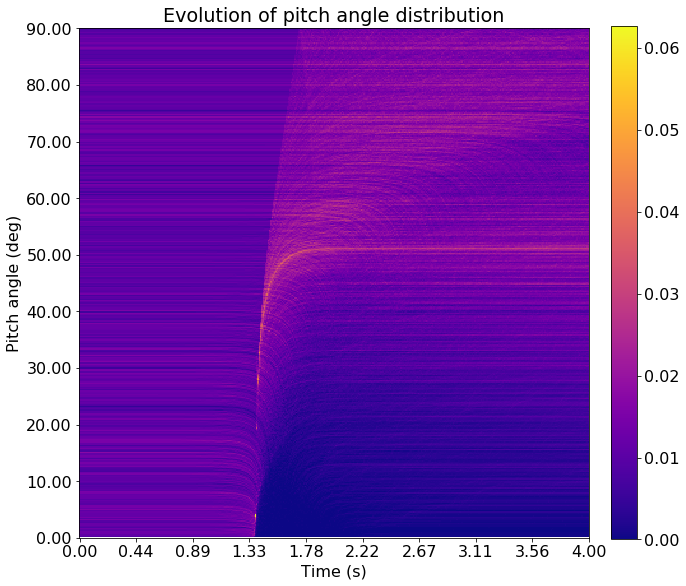

In [7]:
clamped_pa_evolution(system.history, 400, 400, 4)

In [8]:
v_par, v_par_mag = velocity_par(system.history)
v = velocity(system.history)

In [41]:
mus = np.arccos(v_par_mag[:, 0] / np.linalg.norm(v[:, 0], axis=1))

In [42]:
D_uus = (np.arccos(v_par_mag[:, -1] / np.linalg.norm(v[:, -1], axis=1)) - np.arccos(v_par_mag[:, 0] / np.linalg.norm(v[:, 0], axis=1)))**2 / (2 * 4)

In [11]:
moms = eq_pitch_angle_from_moment(system.history, system.ics[:, 4, 0:2])

In [12]:
mus = 0.5 * np.sin(moms[:, 0])**2

In [13]:
D_uus = (0.5 * np.sin(moms[:, -1])**2 - 0.5 * np.sin(moms[:, 0])**2)**2 / (2 * 4)

In [51]:
bins = 30
k = (np.pi / 2) / bins

D_uu_map = [[] for k in range(bins)]

for i, l in enumerate([int(j) for j in mus // k]):
    D_uu_map[l].append(D_uus[i])
    
for j in range(bins):
    if len(D_uu_map[j]) == 0:
        D_uu_map[j].append(0)
        
    D_uu_map[j] = np.mean(D_uu_map[j])

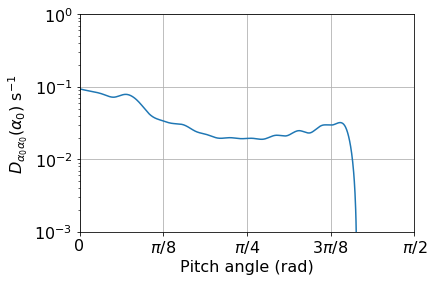

In [53]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max

spl = make_interp_spline(np.linspace(0, np.pi / 2, bins), D_uu_map, k=3)  # type: BSpline
power_smooth = spl(np.linspace(0, np.pi / 2, 1000))

plt.semilogy(np.linspace(0, np.pi / 2, 1000), power_smooth)
plt.xlim([0, np.pi/2])
plt.xticks(np.linspace(0, np.pi/2, 5), [0, r'$\pi/8$', r'$\pi/4$', r'$3\pi/8$', r'$\pi/2$'])
plt.ylim([1e-3, 1])
plt.xlabel('Pitch angle (rad)')
plt.ylabel(r'$D_{\alpha_0\alpha_0}(\alpha_0)$ s$^{-1}$')
plt.title('Equatorial angle diffusion coefficient')
plt.grid()
plt.show()

In [ ]:
pas = pitch_angle(system.history)
B = 1.0111874208e-7
B0 = 100e-9
eq_pas = np.degrees(np.arcsin(np.sqrt(B0 / B) * np.sin(np.radians(pas))))
norm_mom = 0.5 * np.sin(eq_pas)**2

D_uus = (norm_mom[:, -1] - norm_mom[:, 0])**2 / (2 * 8)
mus = norm_mom[:, 0]